In [2]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import json

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision as tv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from PIL import Image

from trainer import Trainer
from data import ChallengeDataset

In [3]:
IMAGE_PATH = os.path.join(os.environ["HUK_CHAL"], "data", 'imgs')
CSV_PATH = os.path.join(os.environ["HUK_CHAL"], "data", 'car_data_4000.csv')
EXPERIMENTS_PATH = os.path.join(os.environ["HUK_CHAL"], "experiments")
CHECKPOINT_PATH = os.path.join(os.environ["HUK_CHAL"], "checkpoints")

In [4]:
df = pd.read_csv(os.path.join(os.environ["HUK_CHAL"], "data", 'car_imgs_4000.csv'))

### Check for Duplicate Images

In [10]:
# Group the dataframe by the perspective scores
df_group = df.groupby(['perspective_score_hood', 'perspective_score_backdoor_left'])

# Find duplicates using MSE between images
duplicates = []
for name, group in df_group:
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            img1 = np.array(Image.open(os.path.join(IMAGE_PATH, group.iloc[i]['filename'])))
            img2 = np.array(Image.open(os.path.join(IMAGE_PATH, group.iloc[j]['filename'])))
            mse = mean_squared_error(img1.ravel(), img2.ravel())

            if mse < 5.0:
                duplicates.append((group.iloc[i]['filename'], group.iloc[j]['filename'], mse))

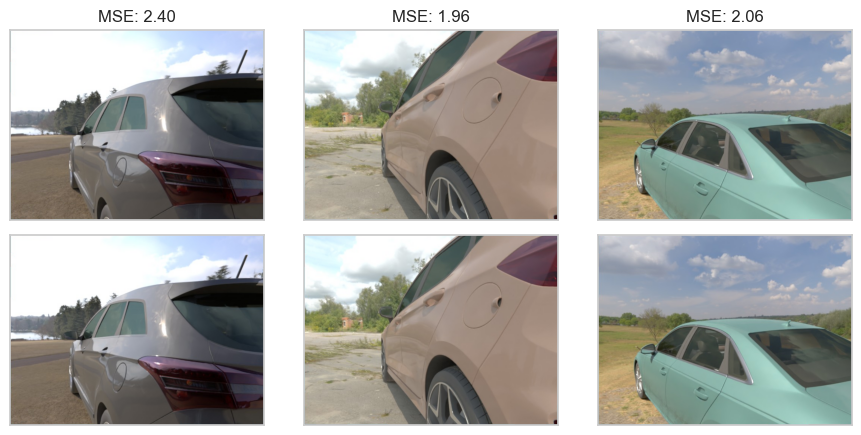

In [12]:
fig, ax = plt.subplots(2, len(duplicates), figsize=(len(duplicates) * 3, len(duplicates) * 1.5))

for col, (dup1, dup2, mse) in enumerate(duplicates):
    img1 = np.array(Image.open(os.path.join(IMAGE_PATH, dup1)))
    img2 = np.array(Image.open(os.path.join(IMAGE_PATH, dup2)))

    ax[0][col].set_title(f"MSE: {mse:.2f}")
    ax[0][col].imshow(img1)
    ax[1][col].imshow(img2)

# Disable ticks
for ax in ax.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

### Visualize Distribution of Target Values

#### Univariate Distribution

In [235]:
sns.set(style="whitegrid")

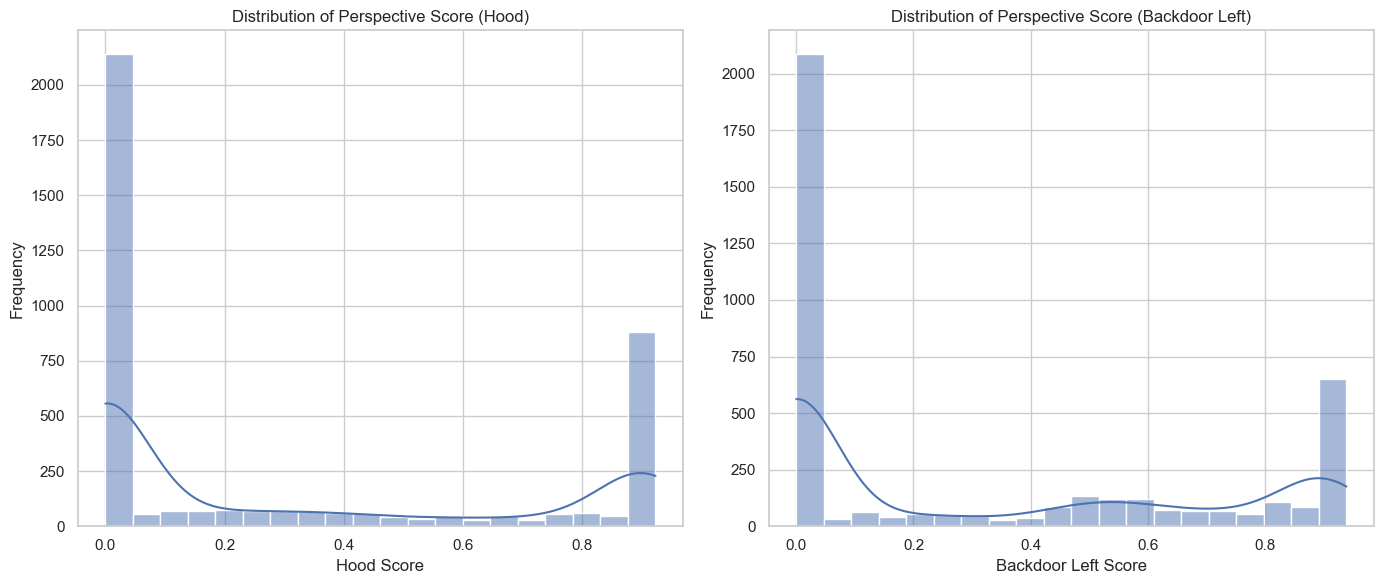

In [286]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Distribution plot for hood score
sns.histplot(df['perspective_score_hood'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Perspective Score (Hood)')
axes[0].set_xlabel('Hood Score')
axes[0].set_ylabel('Frequency')

# Distribution plot for backdoor left score
sns.histplot(df['perspective_score_backdoor_left'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Perspective Score (Backdoor Left)')
axes[1].set_xlabel('Backdoor Left Score')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Multivariate Distribution

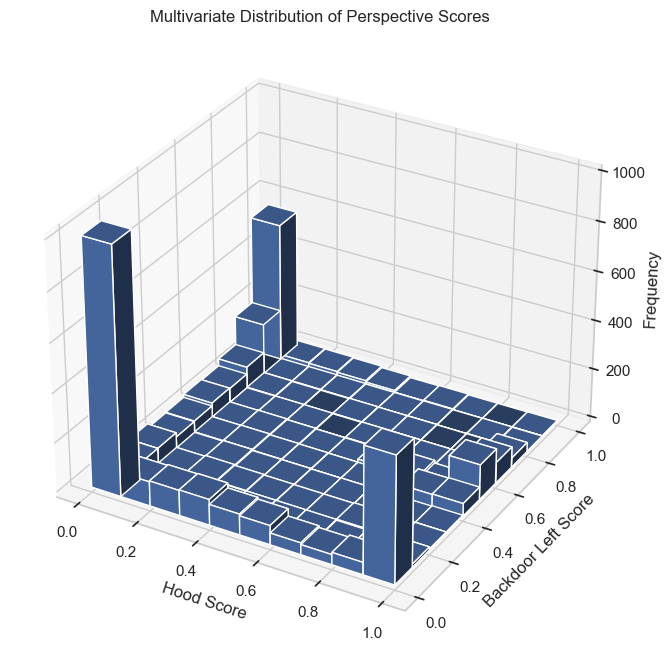

In [288]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(projection='3d')
x, y = np.random.rand(2, 100) * 4
hist, xedges, yedges = np.histogram2d(df['perspective_score_hood'], df['perspective_score_backdoor_left'], bins=10, range=[[0, 1], [0, 1]])

xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.1 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax.set_title('Multivariate Distribution of Perspective Scores')
ax.set_xlabel('Hood Score')
ax.set_ylabel('Backdoor Left Score')
ax.set_zlabel('Frequency')

plt.show()

### Compare Different Models

In [6]:
def plot_comparison(title, model_names, labels=None):
    plt.figure(figsize=(6, 4))
    colors =  ["red", "blue", "green", "purple"]
    labels = model_names if not labels else labels

    for name, label, color in zip(model_names, labels, colors):
        path = os.path.join(EXPERIMENTS_PATH, name, f"progress.csv")
        progress_df = pd.read_csv(path)

        plt.plot(progress_df['avg_mse'], label=f"{label}")
        plt.gca().lines[-1].set_color(color)
        plt.gca().lines[-1].set_alpha(0.6)

    plt.xticks(np.arange(0, 5), np.arange(1, 6))
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel("Average RMSE")
    plt.legend()

    plt.tight_layout()
    plt.show()

#### ResNets of Different Capacity

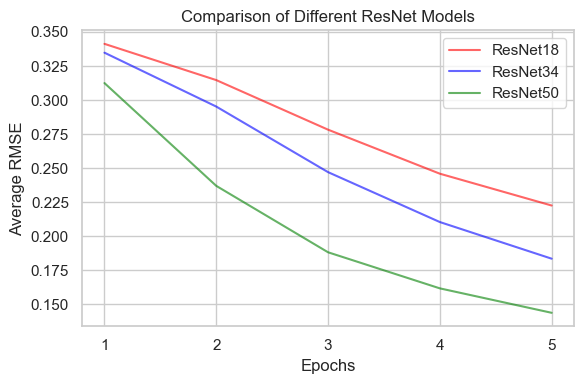

In [263]:
model_names = ["ResNet18", "ResNet34", "ResNet50"]
plot_comparison("Comparison of Different ResNet Models", model_names)

#### Training with Momentum and L2-Regularization

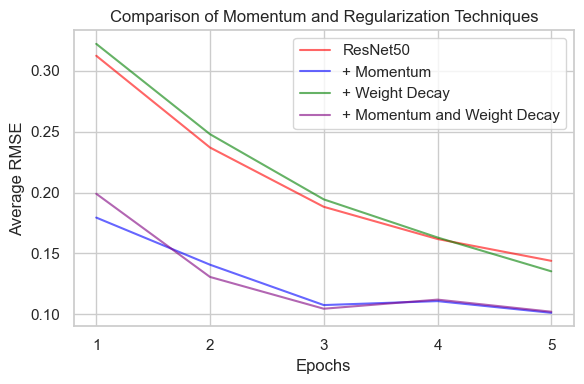

In [292]:
model_names = ["ResNet50", "Momentum", "L2_Regularization", "Momentum+L2"]
labels = ["ResNet50", "+ Momentum", "+ Weight Decay", "+ Momentum and Weight Decay"]
plot_comparison("Comparison of Momentum and Regularization Techniques", model_names, labels)

#### Training with Data Augmentation

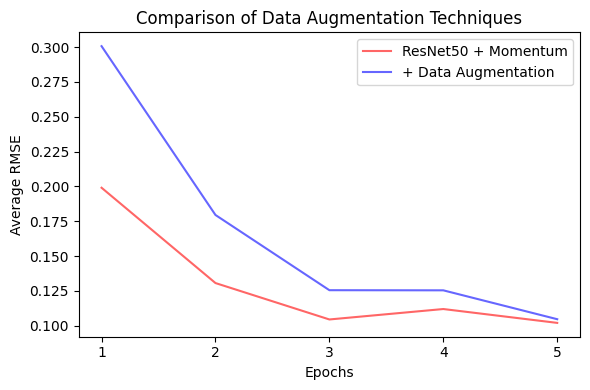

In [7]:
model_names = ["Momentum+L2", "DataAugmentation+Perspec"]
labels = ["ResNet50 + Momentum", "+ Data Augmentation"]
plot_comparison("Comparison of Data Augmentation Techniques", model_names, labels)

### Analyze Differences in Score Errors of the Best Model

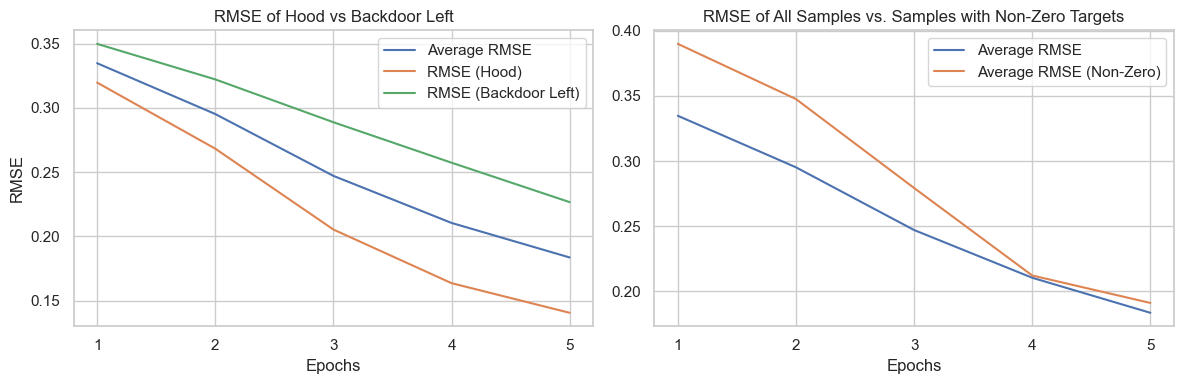

In [296]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
colors =  ["red", "blue", "green", "purple"]

path = os.path.join(EXPERIMENTS_PATH, "ResNet34", "progress.csv")
progress_df = pd.read_csv(path)

ax[0].plot(progress_df['avg_mse'], label=f"Average RMSE")
ax[0].plot(progress_df['mse_hood'], label=f"RMSE (Hood)")
ax[0].plot(progress_df['mse_backdoor_left'], label=f"RMSE (Backdoor Left)")

ax[0].set_xticks(np.arange(0, 5), np.arange(1, 6))
ax[0].set_title("RMSE of Hood vs Backdoor Left")
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel("RMSE")
ax[0].legend()

ax[1].plot(progress_df['avg_mse'], label=f"Average RMSE")
ax[1].plot(progress_df['non_zero_mse'], label=f"Average RMSE (Non-Zero)")
ax[1].set_xticks(np.arange(0, 5), np.arange(1, 6))
ax[1].set_title("RMSE of All Samples vs. Samples with Non-Zero Targets")
ax[1].set_xlabel('Epochs')
ax[1].legend()

plt.tight_layout()
plt.show()

### Analyze Samples with Highest Prediction Error

In [14]:
state_dict = torch.load(os.path.join(CHECKPOINT_PATH, "ResNet50_momentum_data_aug1.pth"), map_location="cuda")

model = tv.models.resnet50(weights=tv.models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 2), nn.Sigmoid())
model.load_state_dict(state_dict["model_state_dict"])

dataloader = torch.utils.data.DataLoader(ChallengeDataset(df, "val"), batch_size=32, num_workers=4)
trainer = Trainer(model=model, loss=nn.MSELoss(), val_dl=dataloader)
y_preds, y_grounds, val_loss = trainer.validate()
diff = np.abs(y_preds - y_grounds)

top_10_hood_score = np.sort(diff[:, 0])[-10:]
top_10_hood_score_idx = np.argsort(diff[:, 0])[-10:]

top_10_backdoor_left_score = np.sort(diff[:, 1])[-10:]
top_10_backdoor_left_score_idx = np.argsort(diff[:, 1])[-10:]

#### Worst Hood Scores

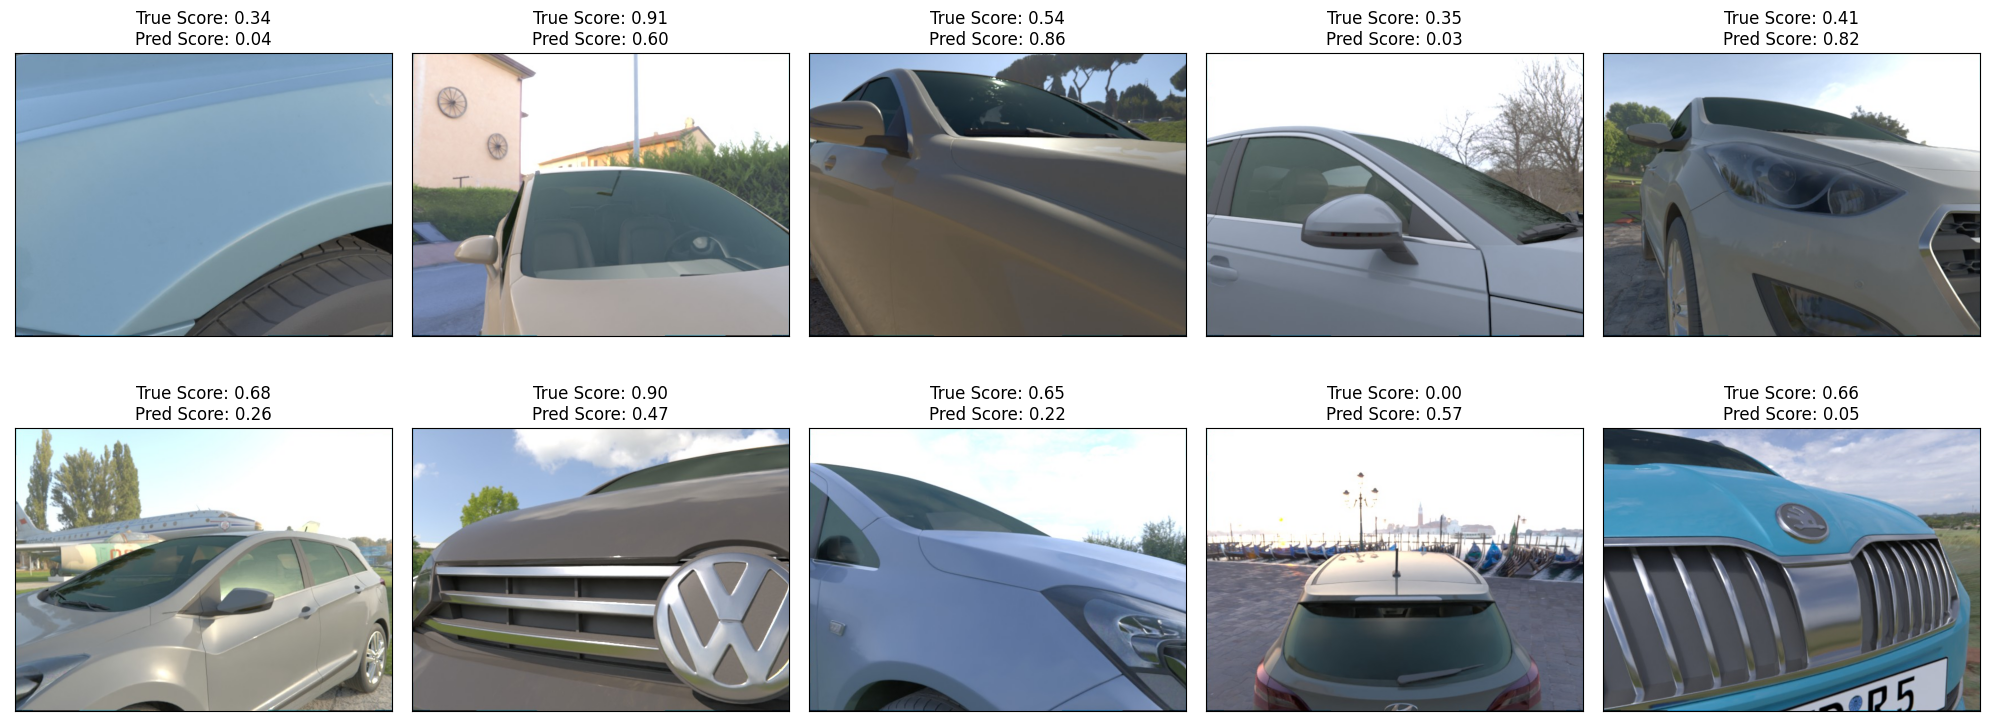

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))

for i, idx in enumerate(top_10_hood_score_idx):
    filename = df.loc[idx, 'filename']
    img = np.array(Image.open(os.path.join(IMAGE_PATH, filename)))
    axis = ax.flatten()[i]
    axis.imshow(img)
    axis.set_xticks([])
    axis.set_yticks([])
    true_score = df.loc[idx, 'perspective_score_hood']
    axis.set_title(f"True Score: {true_score:.2f}\nPred Score: {y_preds[idx, 0]:.2f}")

plt.tight_layout()

#### Worst Backdoor-Left Scores

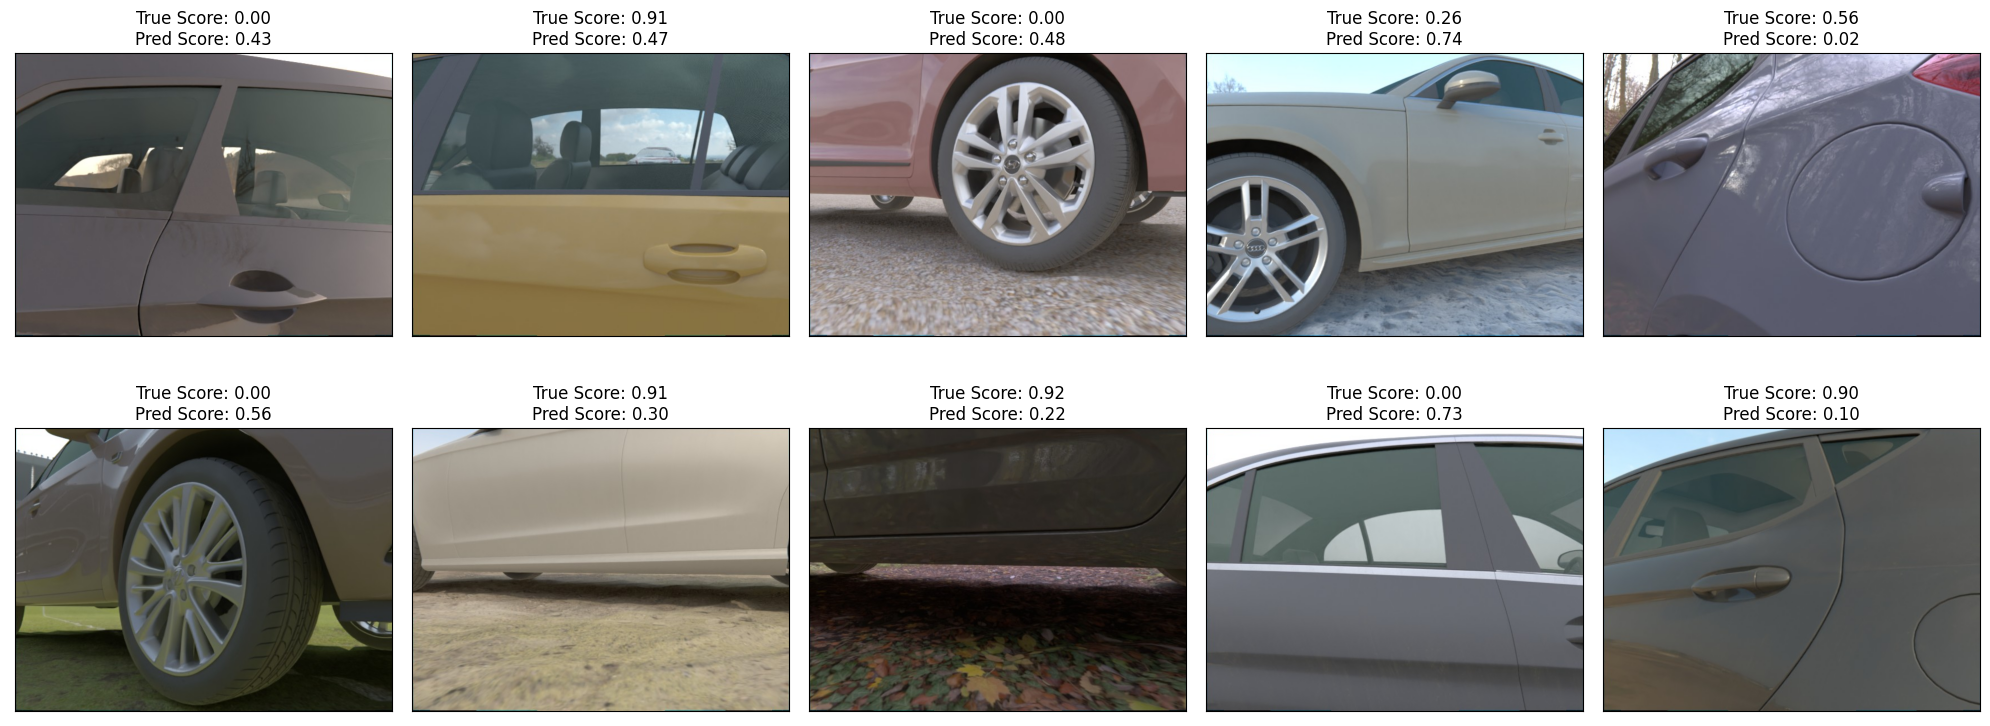

In [16]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))

for i, idx in enumerate(top_10_backdoor_left_score_idx):
    filename = df.loc[idx, 'filename']
    img = np.array(Image.open(os.path.join(IMAGE_PATH, filename)))
    axis = ax.flatten()[i]
    axis.imshow(img)
    axis.set_xticks([])
    axis.set_yticks([])
    true_score = df.loc[idx, 'perspective_score_backdoor_left']
    axis.set_title(f"True Score: {true_score:.2f}\nPred Score: {y_preds[idx, 1]:.2f}")

plt.tight_layout()

### MISC

#### Test Image Augmentation

In [95]:
def plot_image_comparison(orig_image, augmented_image):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(orig_image)
    ax[0].set_title("Original Image")
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(augmented_image)
    ax[1].set_title("Augmented Image")
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    plt.tight_layout()
    plt.show()

In [120]:
image = Image.open(os.path.join(IMAGE_PATH, "fe2e2cc9-4652-423e-9df9-62fee7476844.jpg"))

##### Rotation

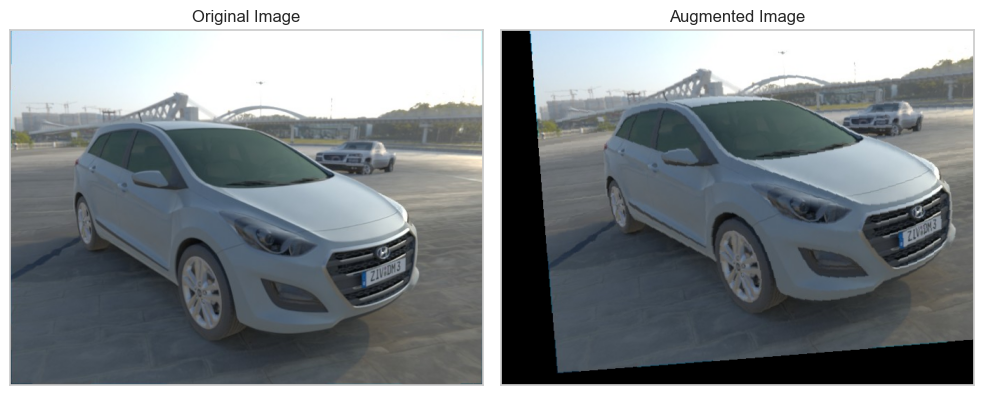

In [307]:
rotation = tv.transforms.RandomAffine(degrees=15, translate=(0.1, 0.1))
rotation_image = rotation(image)

plot_image_comparison(image, rotation_image)

##### Color Jitter

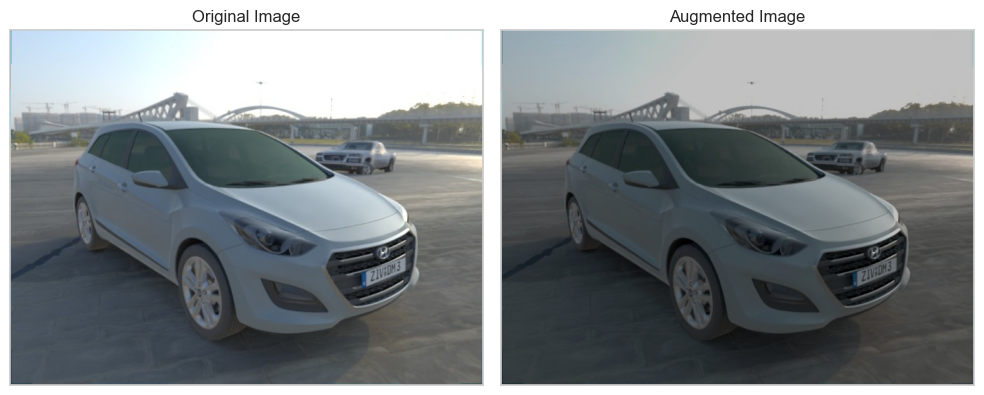

In [303]:
color_jitter = tv.transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1)
jittered_image = color_jitter(image)

plot_image_comparison(image, jittered_image)

##### Perspective Transformation

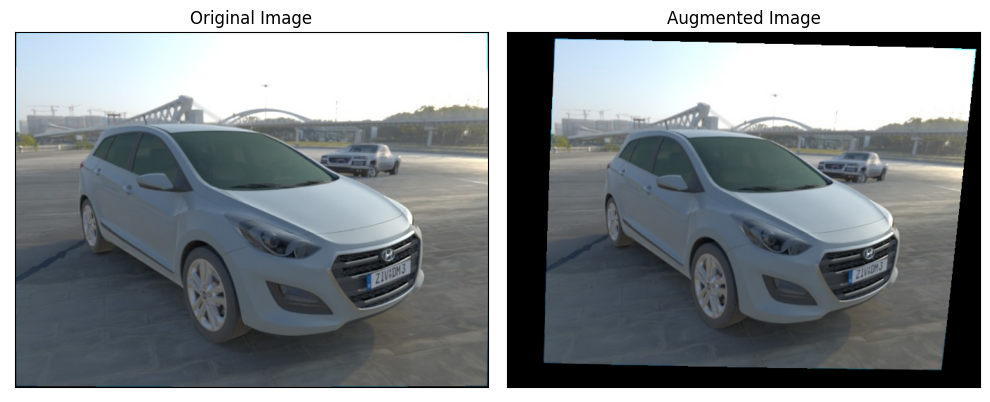

In [203]:
perspective = tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.5)
transformed_image = perspective(image)

plot_image_comparison(image, transformed_image)

#### Precompute Mean and Standard Deviation

In [ ]:
channel_mean = [0, 0, 0]
channel_std = [0, 0, 0]

for img_name in df['filename']:
    img = np.array(Image.open(os.path.join(IMAGE_PATH, img_name)))
    channel_mean[0] += (img[..., 0] / 255).mean()
    channel_mean[1] += (img[..., 1] / 255).mean()
    channel_mean[2] += (img[..., 2] / 255).mean()

    channel_std[0] += (img[..., 0] / 255).std()
    channel_std[1] += (img[..., 1] / 255).std()
    channel_std[2] += (img[..., 2] / 255).std()


channel_mean = np.array(channel_mean) / len(df)
channel_std = np.array(channel_std) / len(df)

print(channel_mean, channel_std)